In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path as p
from pathlib import Path
import cv2 as cv
from tqdm import tqdm
from glob import glob

In [34]:
datasets = ['dermis', 'dermquest', 'isic']

out_of_sample = True
stratified_sampling = False

if out_of_sample:
    if stratified_sampling:
        prediction_files = [f'predictions/dermis_unet_strat/metrics_seg_dermquest.csv', f'predictions/dermquest_unet_strat/metrics_seg_dermis.csv']
    else:
        prediction_files = [f'predictions/dermis_unet/metrics_seg_dermquest.csv', f'predictions/dermquest_unet/metrics_seg_dermis.csv']
    prediction_dfs = [pd.read_csv(f) for f in prediction_files]
    skin_color_dfs = [pd.read_csv(f'data/{d}/skin_color_prediction.csv') for d in ['dermquest', 'dermis']]
    dataset_names = ['dermquest', 'dermis']
else:
    prediction_dfs = [pd.read_csv(f'predictions/{dataset}_unet/metrics_seg_{dataset}.csv') for dataset in datasets]
    skin_color_dfs = [pd.read_csv(f'data/{dataset}/skin_color_prediction.csv') for dataset in datasets]
    dataset_names = datasets

dataset_dfs = []

for (pred_df, skin_df, name) in zip(prediction_dfs, skin_color_dfs, dataset_names):
    skin_df.rename(columns={'file_name': 'subject'}, inplace=True)
    df_merged = pd.merge(pred_df, skin_df, on='subject')
    df_merged['dataset'] = name
    dataset_dfs.append(df_merged)

df = pd.concat(dataset_dfs)

def get_file_name_for_row(row):
    folder = f'data/{row["dataset"]}'
    file_name = glob(folder + f'/**/*/{row["subject"]}.jpg', recursive=True)[0]
    return file_name

<Axes: xlabel='ita_angle', ylabel='Density'>

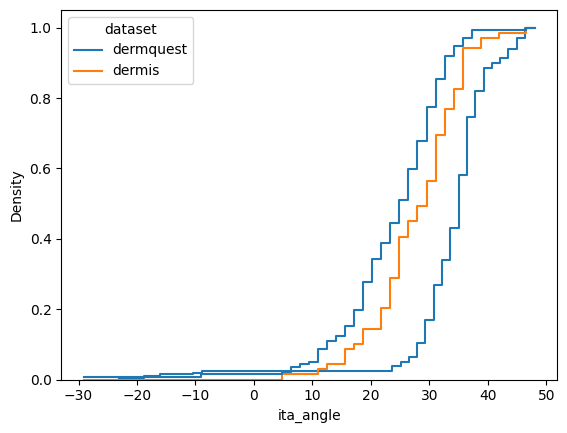

In [35]:
# plot ita angle for each dataset

# what about ph2?
ph2_skin_df = pd.read_csv('data/ph2/skin_color_prediction.csv')

sns.histplot(data=ph2_skin_df, x='ita_angle', bins=50, common_norm=False, stat='density', cumulative=True, element='step', fill=False, label='ph2')
sns.histplot(data=df, x='ita_angle', hue='dataset', bins=50, common_norm=False, stat='density', cumulative=True, element='step', fill=False)

Text(0.5, 0, 'log(p(skin color = 56))')

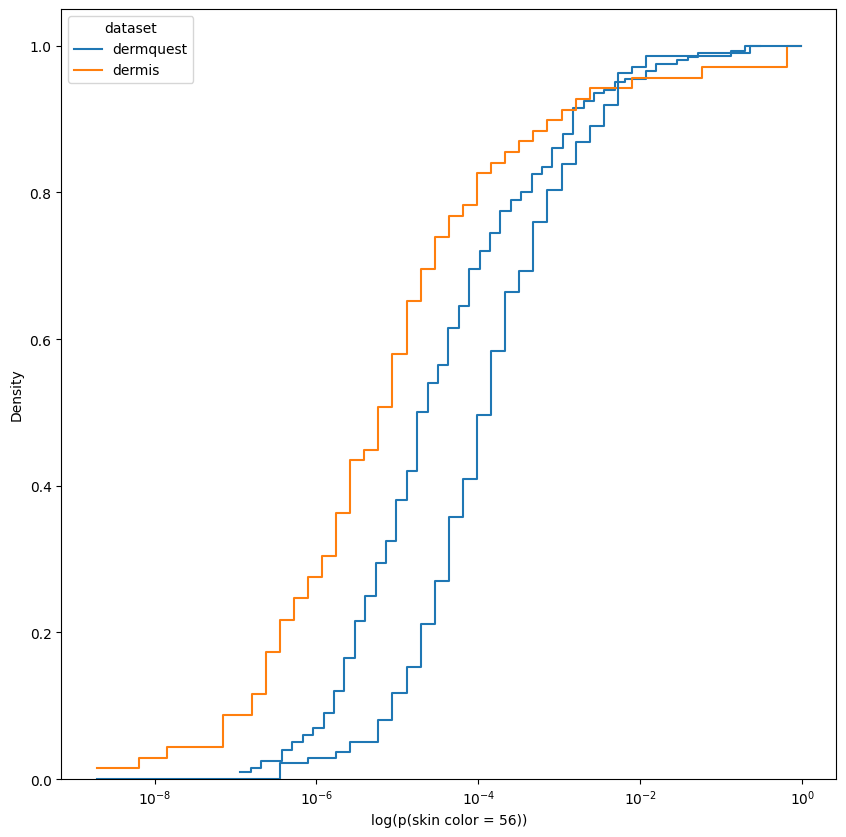

In [36]:
# plot f0_c2 for each dataset
fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=ph2_skin_df, x='f0_c2', bins=50, log_scale=True, common_norm=False, stat='density', cumulative=True, element='step', fill=False, label='ph2', ax=ax)
sns.histplot(data=df, x='f0_c2', hue='dataset', bins=50, log_scale=True, common_norm=False, stat='density', cumulative=True, element='step', fill=False, ax=ax)
ax.set_xlabel('log(p(skin color = 56))')

In [37]:
df.head()

,subject,dsc,hd,assd,prec,rec,skin_type,f0_c0,f0_c1,f0_c2,...,nn_skin_type,color_r,color_g,color_b,ita_angle,kmeans_skin_type,f4_c0,f4_c1,f4_c2,dataset
0,D10_1_orig,0.916719,5.000000,1.732433,0.966733,0.871626,12.0,0.480830,0.518136,0.001034,...,12,162.0,123.0,106.0,22.185106,34.0,0.463712,0.530946,0.005343,dermquest
1,D19_orig,0.902996,4.123106,1.513692,0.998876,0.823911,34.0,0.001854,0.991559,0.006587,...,34,178.0,128.0,92.0,22.038598,34.0,0.009861,0.891126,0.099013,dermquest
2,D28_2_orig,0.933221,20.591260,2.862260,0.901459,0.967301,34.0,0.004900,0.994972,0.000128,...,34,187.0,116.0,77.0,19.744881,34.0,0.050773,0.949071,0.000156,dermquest
3,D43_orig,0.939505,5.000000,1.031066,0.996555,0.888633,12.0,0.838713,0.161256,0.000031,...,12,175.0,140.0,110.0,25.172276,34.0,0.641700,0.358165,0.000135,dermquest
4,D45_orig,0.933007,16.155494,1.574901,0.950874,0.915798,12.0,0.452978,0.546735,0.000286,...,34,-1.0,-1.0,-1.0,48.019747,12.0,0.530068,0.468907,0.001025,dermquest


In [38]:
df['nn_skin_type'].value_counts(ascending=True)

nn_skin_type
56      3
34     49
12    154
Name: count, dtype: int64

In [39]:
from scipy.stats import spearmanr, ttest_ind, pearsonr

c2s = df[['f0_c2', 'f1_c2', 'f2_c2', 'f3_c2']].mean(axis=1)
c1s = df[['f0_c1', 'f1_c1', 'f2_c1', 'f3_c1']].mean(axis=1)
c0s = df[['f0_c0', 'f1_c0', 'f2_c0', 'f3_c0']].mean(axis=1)

print('p(skin type = 56) vs dsc')
print(spearmanr(c2s, df['dsc']))

print('p(skin type = 34) vs dsc')
print(spearmanr(c1s, df['dsc']))

print('p(skin type = 12) vs dsc')
print(spearmanr(c0s, df['dsc']))

print('ITA angle vs dsc')
print(spearmanr(df['ita_angle'], df['dsc']))

dscs_log = np.log(1 - df['dsc'])
dscs_dark = dscs_log[df['nn_skin_type'] == 56]
dscs_medium = dscs_log[df['nn_skin_type'] == 34]
dscs_light = dscs_log[df['nn_skin_type'] == 12]

print('dark vs medium')
print(ttest_ind(dscs_dark, dscs_medium))
print('dark vs light')
print(ttest_ind(dscs_dark, dscs_light))
print('light vs medium')
print(ttest_ind(dscs_light, dscs_medium))

p(skin type = 56) vs dsc
SpearmanrResult(correlation=-0.31091915562465033, pvalue=5.399839350780562e-06)
p(skin type = 34) vs dsc
SpearmanrResult(correlation=-0.31991749803525893, pvalue=2.7653630031226016e-06)
p(skin type = 12) vs dsc
SpearmanrResult(correlation=0.3089794671690913, pvalue=6.220090709430524e-06)
ITA angle vs dsc
SpearmanrResult(correlation=0.3121861120232056, pvalue=4.920745133022153e-06)
dark vs medium
Ttest_indResult(statistic=0.4114418767622625, pvalue=0.6825069037223832)
dark vs light
Ttest_indResult(statistic=1.6333859972306364, pvalue=0.10441749863043603)
light vs medium
Ttest_indResult(statistic=-4.147219333602167, pvalue=4.9627326952496575e-05)


In [40]:
print('p(skin type = 56) vs hd')
print(spearmanr(c2s, df['assd']))

print('p(skin type = 34) vs dsc')
print(spearmanr(c1s, df['assd']))

print('p(skin type = 12) vs dsc')
print(spearmanr(c0s, df['assd']))

print('ITA angle vs dsc')
print(spearmanr(df['ita_angle'], df['hd']))

dscs_log = df['hd']
dscs_dark = dscs_log[df['nn_skin_type'] == 56]
dscs_medium = dscs_log[df['nn_skin_type'] == 34]
dscs_light = dscs_log[df['nn_skin_type'] == 12]

print('dark vs medium')
print(ttest_ind(dscs_dark, dscs_medium))
print('dark vs light')
print(ttest_ind(dscs_dark, dscs_light))
print('light vs medium')
print(ttest_ind(dscs_light, dscs_medium))

p(skin type = 56) vs hd
SpearmanrResult(correlation=0.14173659085683302, pvalue=0.04213391268619473)
p(skin type = 34) vs dsc
SpearmanrResult(correlation=0.13411373877352112, pvalue=0.054621791347954314)
p(skin type = 12) vs dsc
SpearmanrResult(correlation=-0.1666615188735256, pvalue=0.016654093039261266)
ITA angle vs dsc
SpearmanrResult(correlation=-0.09583428462212569, pvalue=0.1706035910462427)
dark vs medium
Ttest_indResult(statistic=2.656494620610832, pvalue=0.010568889355120854)
dark vs light
Ttest_indResult(statistic=3.369793785355201, pvalue=0.0009494047747416794)
light vs medium
Ttest_indResult(statistic=-2.010821531119614, pvalue=0.04568038304874658)


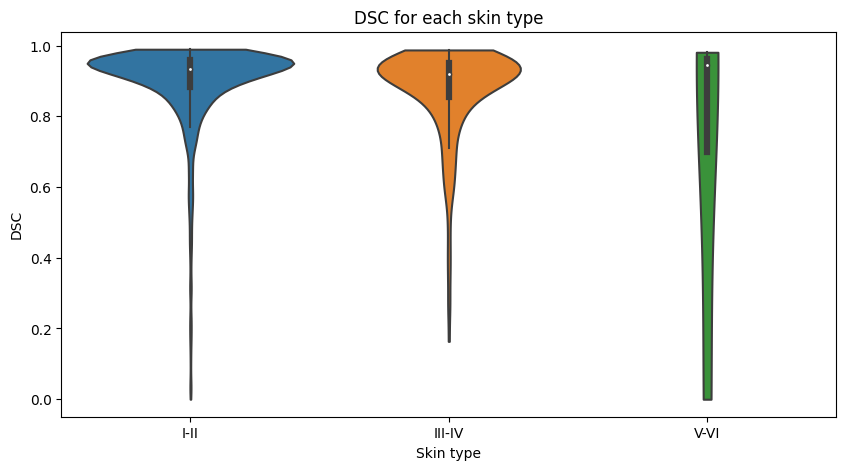

In [9]:
skin_types = [12, 34, 56]
skin_type_names = ['I-II', 'III-IV', 'V-VI']

# plot box plot of DSC for each skin type
plt.figure(figsize=(10, 5))
sns.violinplot(x='nn_skin_type', y='dsc', data=df, order=skin_types, cut=0)
plt.xticks(range(len(skin_types)), skin_type_names)
plt.xlabel('Skin type')
plt.ylabel('DSC')
plt.title('DSC for each skin type')
plt.show()

In [10]:
def get_border_gradient(img, label, border_neighborhood=20):
    contours, hierarchy = cv.findContours(label, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    # get the border neighborhood
    contour_mask = np.zeros(label.shape)
    contour_mask = cv.drawContours(contour_mask, contours, -1, (1, 1, 1), 1)
    contour_mask = contour_mask.astype(np.uint8)
    contour_mask = cv.dilate(contour_mask, np.ones((border_neighborhood, border_neighborhood), np.uint8), iterations=1)
    contour_img = img * contour_mask[:, :, np.newaxis]

    # polar-transform the border neighborhood
    moments = cv.moments(contour_mask)
    center = np.array([[int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00'])]])
    center_ = tuple(center[0].astype(np.float32))
    radius = max(contour_img.shape) // 2
    polar_img = cv.warpPolar(contour_img, (contour_img.shape[1], contour_img.shape[0]), center_, radius, cv.INTER_CUBIC + cv.WARP_POLAR_LINEAR + cv.WARP_FILL_OUTLIERS)

    # # get a rectangular image from the polar-transformed image
    # row_lengths = np.sum(polar_img > 0, axis=1)[:, 0]
    # row_start_locations = np.argmax(polar_img > 0, axis=1)[:, 0]

    # min_possible_length = 12

    # min_length = np.min(row_lengths[row_lengths > min_possible_length])
    # if min_length % 2 == 1:
    #     min_length -= 1

    # polar_border = np.zeros((polar_img.shape[0], min_length, 3), np.uint8)
    # for i in range(polar_img.shape[0]):
    #     if row_lengths[i] < min_possible_length:
    #         continue
    #     row_center = row_start_locations[i] + int(row_lengths[i] / 2)
    #     left = row_center - int(np.round(min_length / 2))
    #     right = row_center + int(np.round(min_length / 2))
    #     if left < 0:
    #         left = 0
    #         right = min_length
    #     if right > polar_img.shape[1]:
    #         right = polar_img.shape[1]
    #         left = right - min_length
        
    #     polar_border[i] = polar_img[i, left:right]

    # remove rows with any black pixel
    # has_zero_pixels = np.sum(polar_border == 0, axis=1)[:, 0] > 0
    # polar_border = polar_border[~has_zero_pixels]

    # contrast along rows
    # polar_border_ = cv.blur(polar_border, (3, 3))
    # polar_border_ = cv.cvtColor(polar_border, cv.COLOR_RGB2LAB)
    # polar_border_ = polar_border.astype(np.float32)

    polar_img = cv.blur(polar_img, (3, 3))
    polar_img_ = cv.cvtColor(polar_img, cv.COLOR_BGR2LAB)
    polar_img_for_min = polar_img_.copy()
    polar_img_for_min[polar_img_for_min == 0] = 255
    contrast = np.zeros(3)
    for c in range(3):
        min_value = np.min(polar_img_for_min[:, :, c], axis=1)
        max_value = np.max(polar_img_[:, :, c], axis=1)
        channel_contrast = max_value - min_value
        contrast[c] = np.mean(channel_contrast)
    mean_contrast = np.mean(contrast)




    # plt.imshow(cv.cvtColor(polar_img_, cv.COLOR_LAB2RGB))
    # plt.show()

    # alpha = 1 - ((mean_contrast / 100.0) - 0.5) * 2
    # polar_img_ = cv.convertScaleAbs(polar_img_, alpha=alpha, beta=0.0)
    # polar_img_ = cv.cvtColor(polar_img, cv.COLOR_BGR2LAB)

    # #plt.imshow(cv.cvtColor(polar_img_, cv.COLOR_LAB2RGB))
    # #plt.show()

    # polar_img_for_min = polar_img_.copy()
    # polar_img_for_min[polar_img_for_min == 0] = 255
    # contrast = np.zeros(3)
    # for c in range(3):
    #     min_value = np.min(polar_img_for_min[:, :, c], axis=1)
    #     max_value = np.max(polar_img_[:, :, c], axis=1)
    #     channel_contrast = max_value - min_value
    #     contrast[c] = np.mean(channel_contrast)
    # mean_contrast_clahe = np.mean(contrast)

    # sobel_total = 0
    # for c in range(3):
    #     polar_border_c = polar_border_[:, :, c]
    #     sobel_x_c = cv.Sobel(polar_border_c, cv.CV_64F, 1, 0, ksize=5)
    #     sobel_total += np.abs(sobel_x_c)
    # mean = np.mean(sobel_total, axis=1)

    return mean_contrast

In [11]:
from glob import glob
from tqdm import tqdm

contrasts = np.zeros(len(df))
for i in tqdm(range(len(df))):
    row = df.iloc[i]
    file_name = get_file_name_for_row(row)
    img = cv.imread(file_name)
    label = cv.imread(file_name.replace('input', 'label').replace('.jpg', '.png'), cv.IMREAD_GRAYSCALE)
    contrasts[i] = get_border_gradient(img, label)

df['border_contrast'] = contrasts

 27%|██▋       | 772/2900 [00:05<00:15, 133.80it/s]


KeyboardInterrupt: 

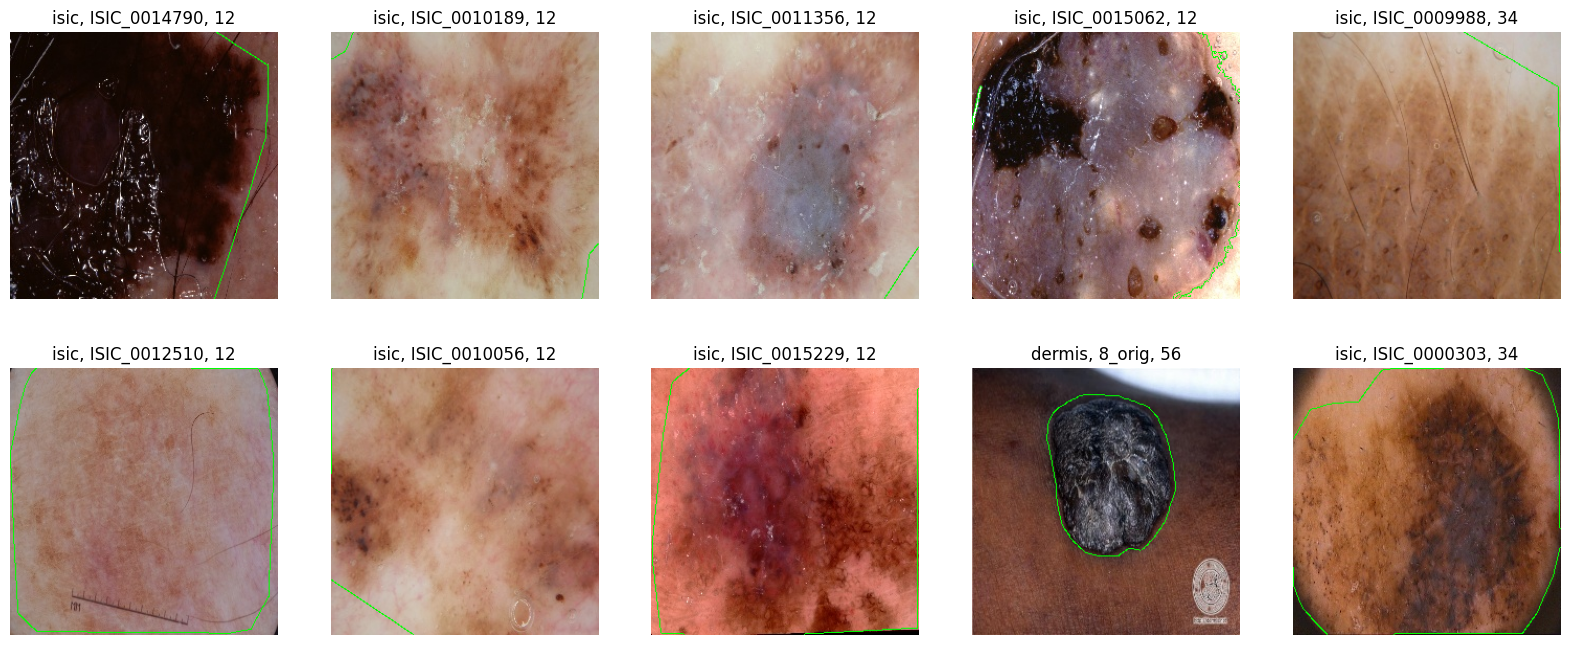

In [13]:
sorting = np.argsort(df['border_contrast'])
lowest_contrast = df.iloc[sorting[:10]]

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    row = lowest_contrast.iloc[i]
    file_name = get_file_name_for_row(row)
    img = cv.imread(file_name)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    label = cv.imread(file_name.replace('input', 'label').replace('.jpg', '.png'), cv.IMREAD_GRAYSCALE)
    label_contour = cv.Canny(label, 100, 200)
    img[label_contour > 0] = [0, 255, 0]

    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].set_title(f'{row["dataset"]}, {row["subject"]}, {row["nn_skin_type"]}')
    axs[i // 5, i % 5].axis('off')

In [14]:
print('p(skin type = 56) vs dsc')
print(spearmanr(c2s, df['dsc']))

print('p(skin type = 56) vs contrast')
print(spearmanr(c2s, df['border_contrast']))

print('contrast vs dsc')
print(spearmanr(df['border_contrast'], df['dsc']))

print('contrast vs ITA')
print(spearmanr(df['border_contrast'], df['ita_angle']))

p(skin type = 56) vs dsc
SpearmanrResult(correlation=-0.060269262284870534, pvalue=0.0011656619992427254)
p(skin type = 56) vs contrast
SpearmanrResult(correlation=-0.026292387128833132, pvalue=0.15691531188500787)
contrast vs dsc
SpearmanrResult(correlation=0.2446772471771213, pvalue=8.536125642046526e-41)
contrast vs ITA
SpearmanrResult(correlation=0.5539534686070736, pvalue=5.923529356975758e-233)


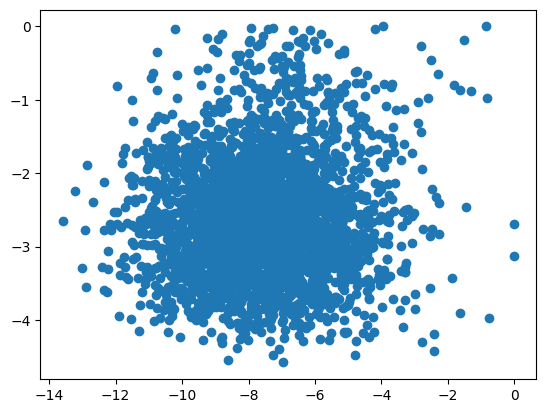

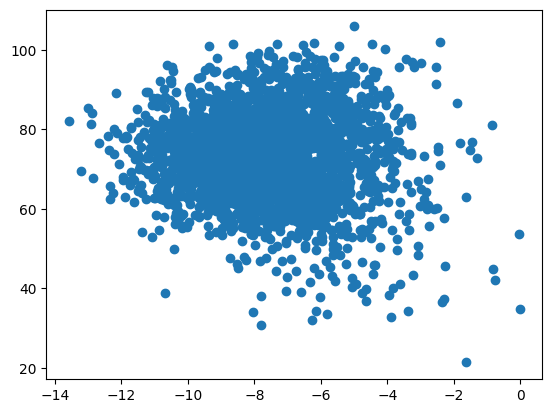

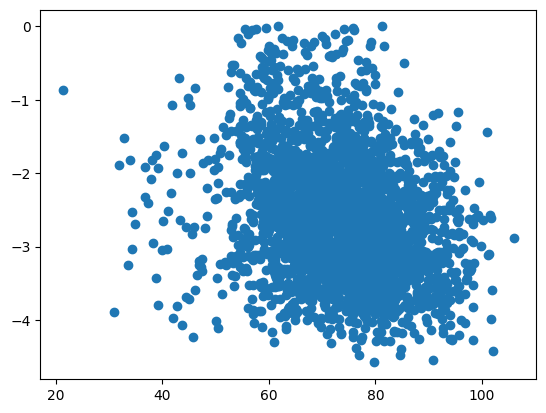

In [15]:
plt.scatter(np.log(c2s), np.log(1 - df['dsc']))
plt.show()

plt.scatter(np.log(c2s), df['border_contrast'])
plt.show()

plt.scatter(df['border_contrast'], np.log(1 - df['dsc']))
plt.show()

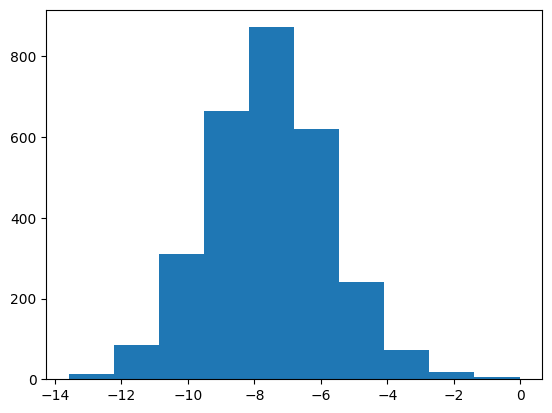

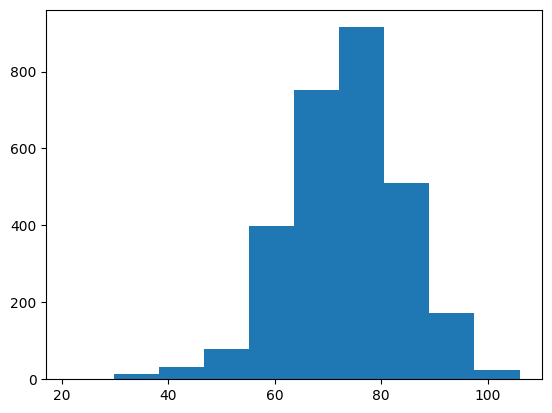

In [16]:
plt.hist(np.log(c2s))
plt.show()
plt.hist(contrasts)
plt.show()

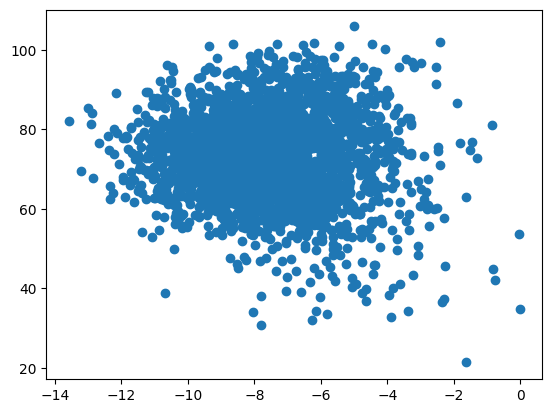

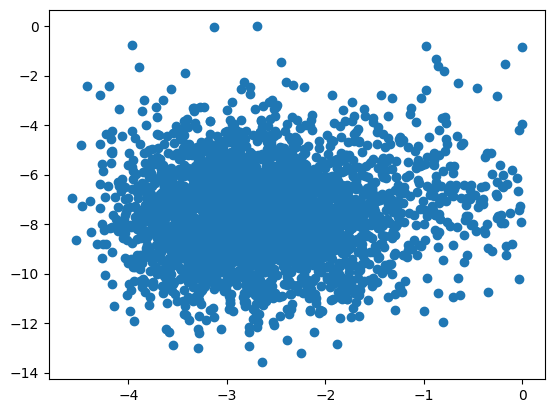

In [17]:
plt.scatter(np.log(c2s), contrasts)
plt.show()

plt.scatter(np.log(1 - df['dsc']), np.log(c2s))
plt.show()

In [42]:
files_56_manual = ['isic_56_manual.txt', 'dermis_56_manual.txt', 'dermquest_56_manual.txt']
names_56_manual = []
for file in files_56_manual:
    with open('data/' + file, 'r') as f:
        names_56_manual += f.read().splitlines()

names_56_manual = [n.replace('.jpg', '') for n in names_56_manual]
metrics_56 = df[df['subject'].isin(names_56_manual)]
metrics_rest = df[~df['subject'].isin(names_56_manual)]

print('56 vs rest')
print(ttest_ind(np.log(1 - metrics_56['dsc']), np.log(1 - metrics_rest['dsc'])))

14
56 vs rest
Ttest_indResult(statistic=2.7508752257291462, pvalue=0.00598056809242525)


In [46]:
# linear regression
from statsmodels.formula.api import ols
from scipy.stats import zscore

df_reg = pd.DataFrame()
df_reg['light'] = (df['nn_skin_type'] == 12) & (~df['subject'].isin(names_56_manual))
df_reg['medium'] = (df['nn_skin_type'] == 34) & (~df['subject'].isin(names_56_manual))
df_reg['dark'] = df['subject'].isin(names_56_manual)
df_reg['log_dsc'] = np.log(1 - df['dsc'])
df_reg['log_c2s'] = np.log(c2s)
df_reg['ita_angle'] = df['ita_angle']
df_reg['border_contrast'] = df['border_contrast']

#df_reg = df_reg.select_dtypes(include=[np.number]).dropna().apply(zscore)

model = ols("log_dsc ~ light + medium + dark", data=df_reg).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                log_dsc   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.466
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           5.61e-05
Time:                        15:25:12   Log-Likelihood:                -3543.6
No. Observations:                2900   AIC:                             7095.
Df Residuals:                    2896   BIC:                             7119.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.9839      0.581     -3.